<a href="https://colab.research.google.com/github/wvirany/mini_projects/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Variational Autoencoder

Adapted from [this tutorial](https://keras.io/examples/generative/vae/).

In [11]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [12]:
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

### Creating a sampling layer

In [18]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

### Building the encoder

In [19]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 3136)           │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 16)             │         50,192 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_3 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

### Building the decoder

In [20]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

### Defining the VAE model

In [21]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
    self.reconstruction_loss_tracker = keras.metrics.Mean(
        name='reconstruction_loss'
    )
    self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:

      # Generating latent-space vector as well as mean and log variance of latent space distributions from input
      z_mean, z_log_var, z = self.encoder(data)

      # Generating reconstructed image from decoder network
      reconstruction = self.decoder(z)

      # Computing element-wise binary cross-entropy between data and reconstruction batches
      reconstruction_loss = ops.mean(
          ops.sum(
              keras.losses.binary_crossentropy(data, reconstruction),
              axis=(1, 2)
          ) # sums binary cross-entropy loss across width and height of image for each sample
      ) # averages the loss over batch of images

      # Computing KL-divergence loss; we want approximate latent distribution to be close to the prior, i.e., a std. Normal
      kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var)) # KL-div takes this form for two Normal distributions
      kl_loss = ops.mean(ops.sum(kl_loss, axis=1))

      # Total loss is sum of KL-divergence and reconstruction loss
      total_loss = reconstruction_loss + kl_loss

    # Computing and applying gradient of total_loss w/ respect to trainable parameters
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # Updating loss trackers
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return{
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

### Training the VAE

In [22]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([X_train, X_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 117s 205ms/step - kl_loss: 1.1909 - loss: 261.2093 - reconstruction_loss: 260.0183
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 130s 184ms/step - kl_loss: 2.8835 - loss: 192.8313 - reconstruction_loss: 189.9478
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 146s 192ms/step - kl_loss: 4.2663 - loss: 180.1779 - reconstruction_loss: 175.9116
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 103s 189ms/step - kl_loss: 5.7876 - loss: 166.3198 - reconstruction_loss: 160.5323
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 141s 187ms/step - kl_loss: 5.9324 - loss: 162.8695 - reconstruction_loss: 156.9371
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 102s 186ms/step - kl_loss: 6.0668 - loss: 160.7739 - reconstruction_loss: 154.7072
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 143s 187ms/step - kl_loss: 6.1600 - loss: 158.7440 - reconstruction_loss: 152.5840
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 139s 181ms/step - kl_loss: 6.1676 - loss: 158.4206 - reconstruction_loss: 152.2530
Epoch 9/30
547/5

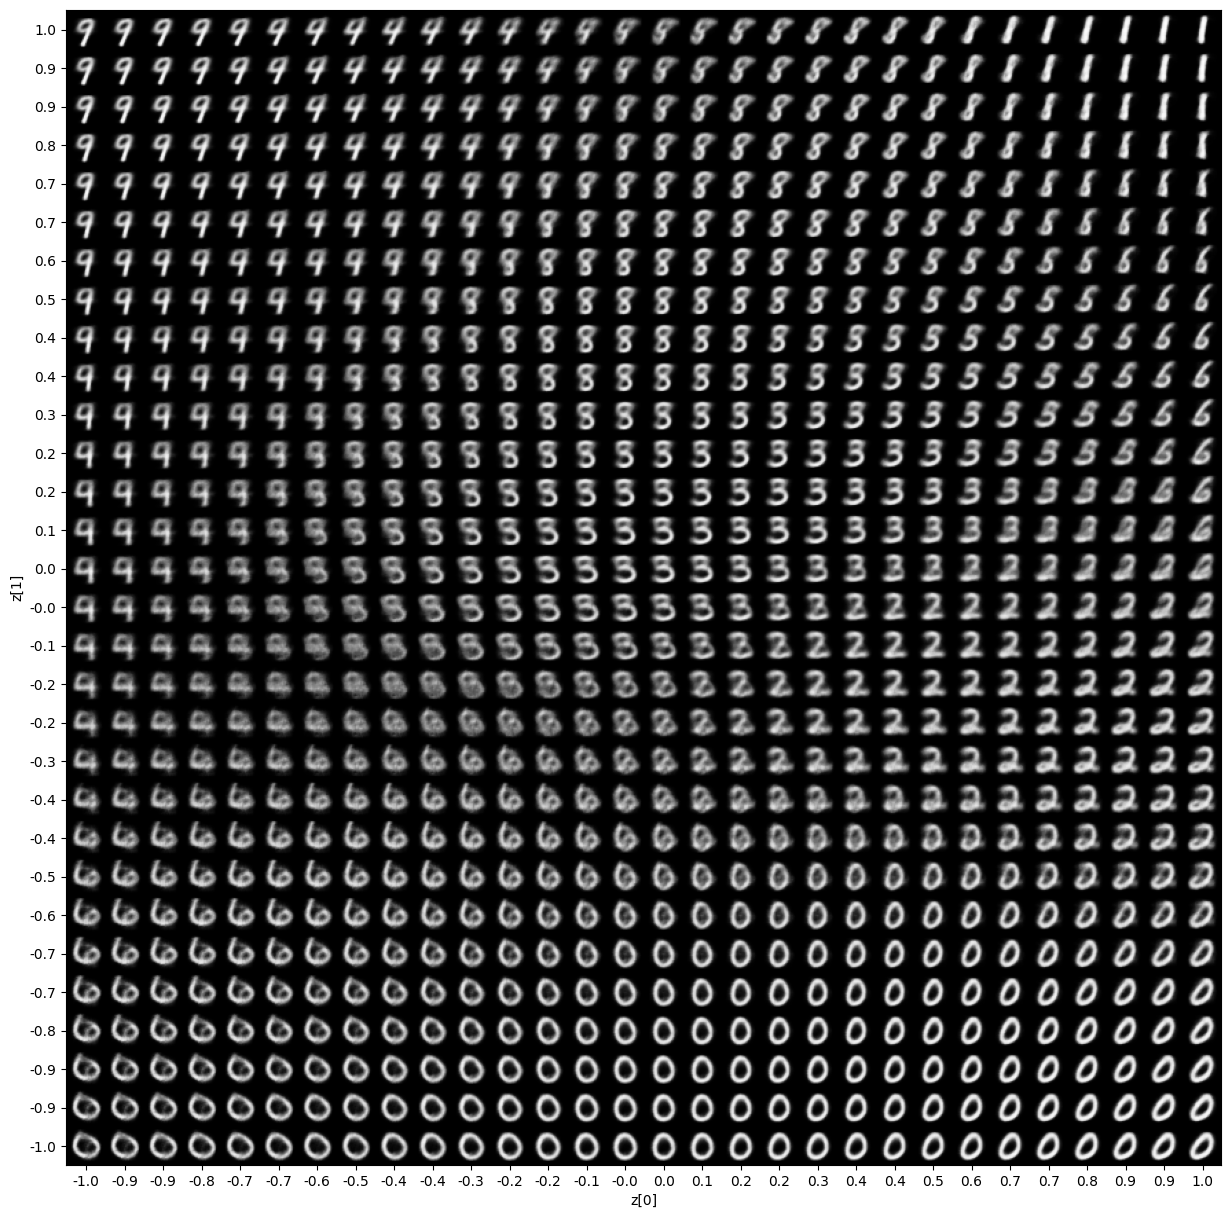

In [26]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

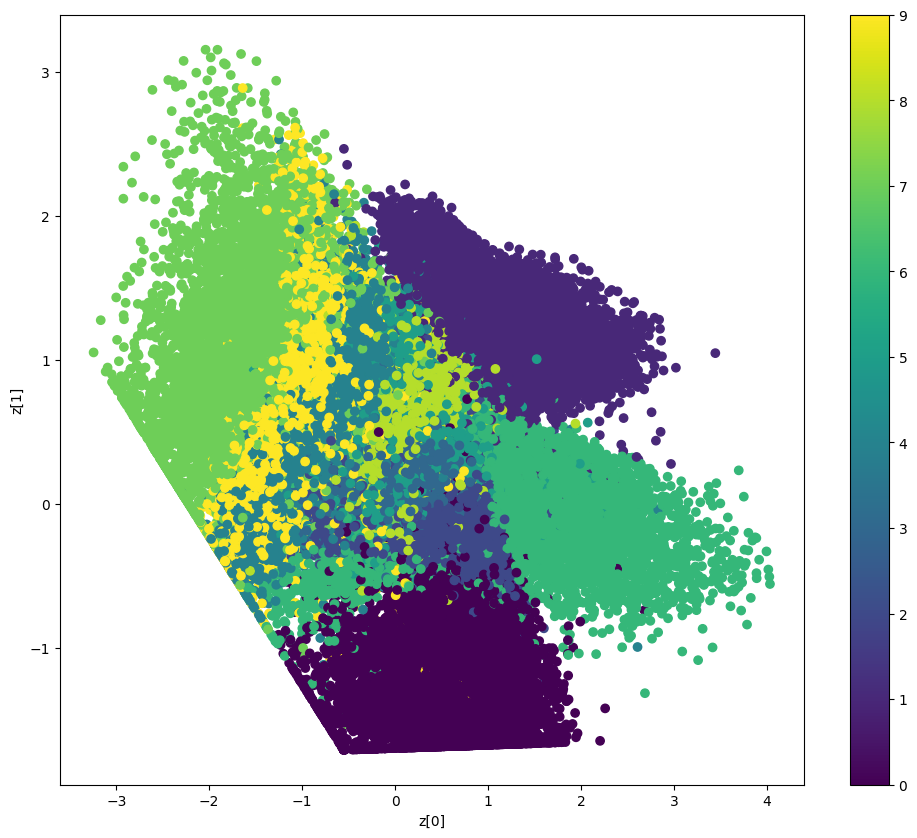

In [27]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)